In [1]:
import numpy as np
from scipy.stats import truncnorm

def sample_truncated_normal(min_val: float, max_val: float, mean: float, std_dev: float, size: int = 1):
    """
    Sample values from a truncated normal distribution.
    
    Args:
        min_val (float): The minimum value of the distribution.
        max_val (float): The maximum value of the distribution.
        mean (float): The mean of the normal distribution.
        std_dev (float): The standard deviation of the normal distribution.
        size (int): Number of samples to generate.
        
    Returns:
        np.ndarray: Array of sampled values.
    """
    # Compute the lower and upper bounds in standard normal units
    lower_bound = (min_val - mean) / std_dev
    upper_bound = (max_val - mean) / std_dev

    # Generate samples from the truncated normal distribution
    samples = truncnorm.rvs(lower_bound, upper_bound, loc=mean, scale=std_dev, size=size)
    return samples


In [7]:
min_val = 80
max_val = 120
mean = 100
std_dev = 2
num_samples = 1

# Generate samples
samples = sample_truncated_normal(min_val, max_val, mean, std_dev, size=num_samples)
print(samples)

[99.63798987]


[ 99.08110301  96.75709227  97.80744216 103.79156176 104.33768109
 102.85328345 101.61006579 101.74968581 100.87260234 100.80185852]


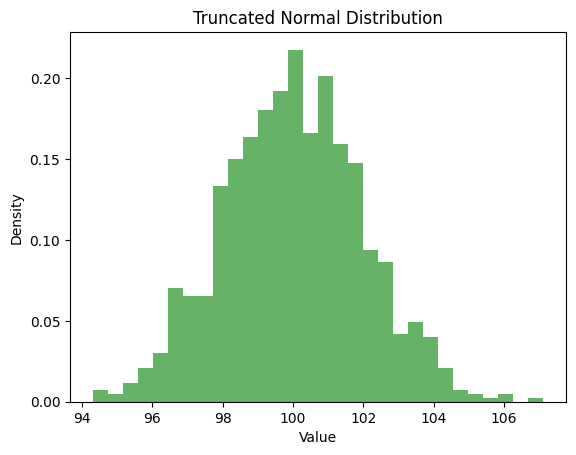

In [6]:
# Define parameters
min_val = 80
max_val = 120
mean = 100
std_dev = 2
num_samples = 1

# Generate samples
samples = sample_truncated_normal(min_val, max_val, mean, std_dev, size=num_samples)

# Check the output
print(samples[:10])  # First 10 samples

# Optional: Visualize the samples
import matplotlib.pyplot as plt
plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
plt.title("Truncated Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()
